Understanding the Data

In [5]:
import os

base_path = r"C:\Users\abedi\OneDrive\Desktop\TumorDetectionProject\data"

# Updated subfolders
for folder in ["Training1", "Training2", "Testing1", "Testing2"]:
    print(f"\n{folder.upper()}")
    folder_path = os.path.join(base_path, folder)
    if os.path.exists(folder_path):
        for cls in os.listdir(folder_path):
            cls_path = os.path.join(folder_path, cls)
            if os.path.isdir(cls_path):
                count = len(os.listdir(cls_path))
                print(f"{cls}: {count} images")
    else:
        print(f"Folder not found: {folder_path}")


TRAINING1
glioma: 1321 images
meningioma: 1339 images
notumor: 1595 images
pituitary: 1457 images

TRAINING2
glioma: 826 images
meningioma: 822 images
notumor: 395 images
pituitary: 827 images

TESTING1
glioma: 300 images
meningioma: 306 images
notumor: 405 images
pituitary: 300 images

TESTING2
glioma: 100 images
meningioma: 115 images
notumor: 105 images
pituitary: 74 images


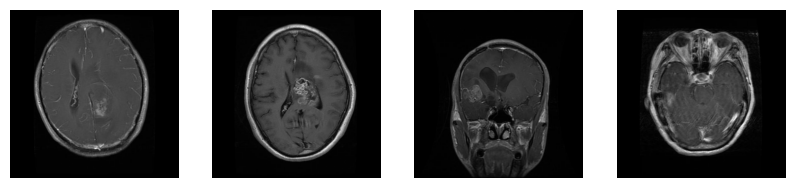

In [6]:
import matplotlib.pyplot as plt
import cv2
import os
import random

# Pick one of the training subfolders
folder = os.path.join(base_path, "training1", "glioma")  # or "training2"

# Sample 4 random images
sample_images = random.sample(os.listdir(folder), 4)

plt.figure(figsize=(10, 4))
for i, img_name in enumerate(sample_images):
    img = cv2.imread(os.path.join(folder, img_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 4, i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [7]:
import cv2

img = cv2.imread(os.path.join(folder, sample_images[0]))
print("Image shape:", img.shape)

Image shape: (512, 512, 3)


Data Augmentation

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Training folders
train_dir1 = r"C:\Users\abedi\OneDrive\Desktop\TumorDetectionProject\data\Training1"
train_dir2 = r"C:\Users\abedi\OneDrive\Desktop\TumorDetectionProject\data\Training2"

# Test folders (used as validation)
test_dir1 = r"C:\Users\abedi\OneDrive\Desktop\TumorDetectionProject\data\Testing1"
test_dir2 = r"C:\Users\abedi\OneDrive\Desktop\TumorDetectionProject\data\Testing2"

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import preprocess_input

def augment_and_preprocess(x):
    x = tf.image.adjust_contrast(x, 1.5)
    return preprocess_input(x)

train_datagen = ImageDataGenerator(
    preprocessing_function=augment_and_preprocess,
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    brightness_range=[0.9, 1.1],
    fill_mode='constant',
    cval=0,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Data Generators
train_gen1 = train_datagen.flow_from_directory(
    train_dir1,
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=True
)

train_gen2 = train_datagen.flow_from_directory(
    train_dir2,
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=True
)

test_gen1 = test_datagen.flow_from_directory(
    test_dir1,
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=False
)

test_gen2 = test_datagen.flow_from_directory(
    test_dir2,
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=False
)

Found 5712 images belonging to 4 classes.
Found 2870 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


In [10]:
# Wrap the generator
def generator_to_dataset(gen):
    return tf.data.Dataset.from_generator(
        lambda: gen,
        output_types=(tf.float32, tf.float32),
        output_shapes=((None, 224, 224, 3), (None, 4))  # batch dimension = None
    )

# Create datasets
ds_train1 = generator_to_dataset(train_gen1)
ds_train2 = generator_to_dataset(train_gen2)
ds_test1 = generator_to_dataset(test_gen1)
ds_test2 = generator_to_dataset(test_gen2)

# Combine
train_dataset = ds_train1.concatenate(ds_train2)
test_dataset = ds_test1.concatenate(ds_test2)

# DO NOT call .batch() here — batches are already in the generator

Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead


Visualizing Augmented Data

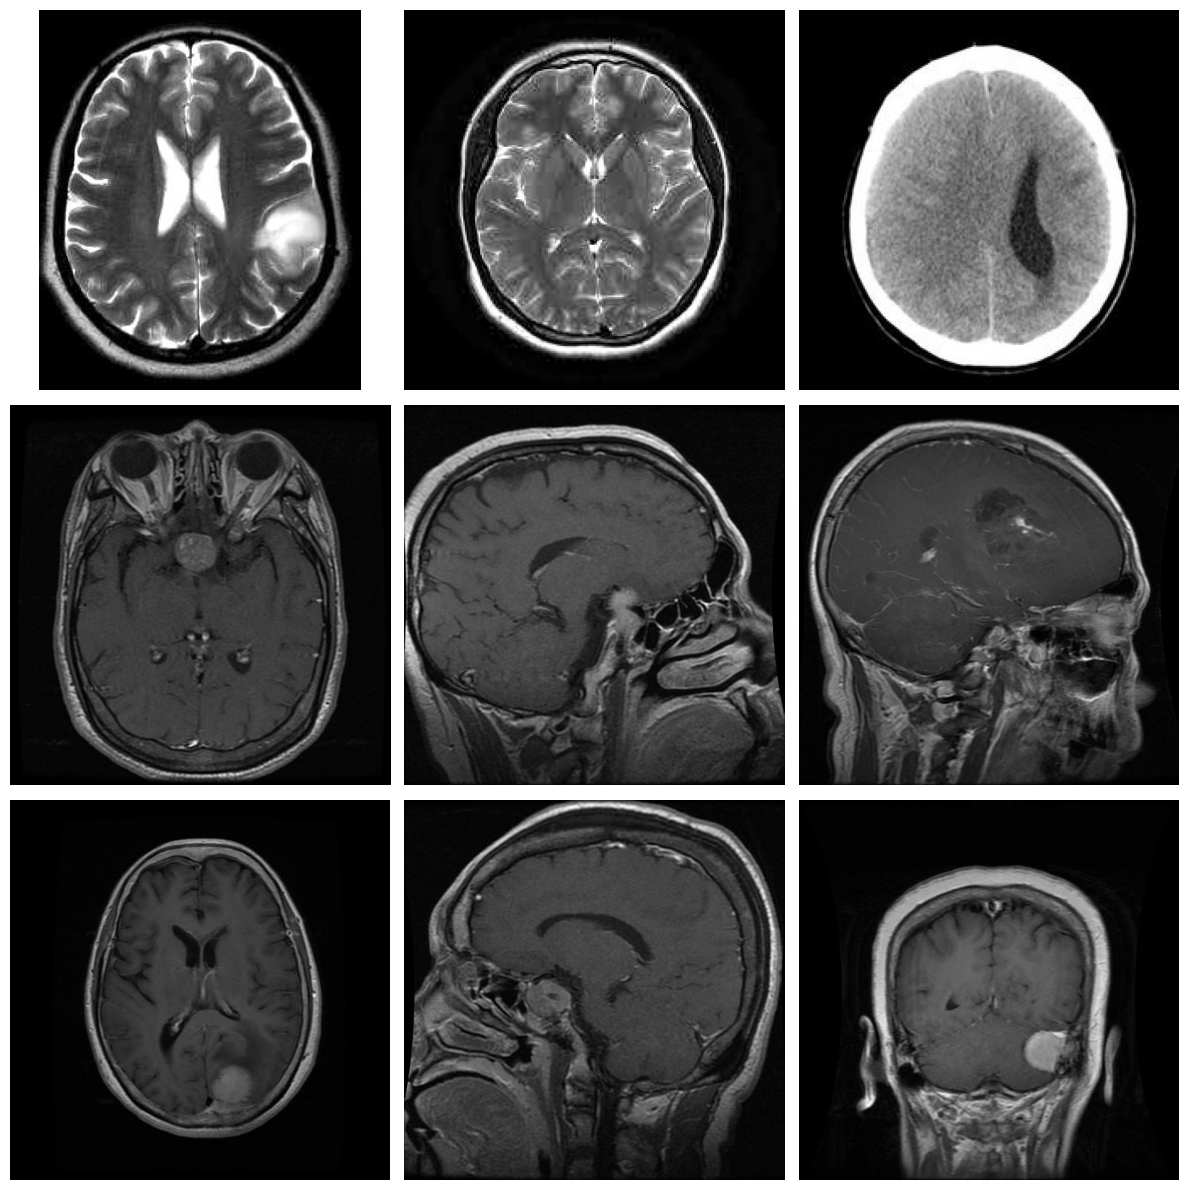

In [11]:
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import os
import random

# Define your training subfolders
training_folders = [train_dir1, train_dir2]

num_images_to_show = 9  # total images to visualize
sample_paths = []

# Collect all class subfolders
all_class_subfolders = []
for folder in training_folders:
    all_class_subfolders += [os.path.join(folder, cls) for cls in os.listdir(folder) if os.path.isdir(os.path.join(folder, cls))]

# Randomly pick 9 images across all classes and folders
while len(sample_paths) < num_images_to_show:
    cls_folder = random.choice(all_class_subfolders)
    img_name = random.choice(os.listdir(cls_folder))
    sample_paths.append(os.path.join(cls_folder, img_name))

# Load images and apply simple augmentations
augmented_images = []
for path in sample_paths:
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = tf.image.convert_image_dtype(img, tf.float32)
    # Simple augmentations
    img = tf.image.random_brightness(img, max_delta=0.1)
    img = tf.image.random_contrast(img, 0.9, 1.1)
    img = tf.image.random_flip_left_right(img)
    augmented_images.append(img)

# Deprocess for visualization
def deprocess_mri_image(x):
    x = (x - tf.reduce_min(x)) / (tf.reduce_max(x) - tf.reduce_min(x) + 1e-8)
    return x.numpy()

# Plot augmented images in 3x3 grid
rows = 3
cols = 3
plt.figure(figsize=(12, 12))  # bigger figure for large images
for i, img in enumerate(augmented_images):
    plt.subplot(rows, cols, i+1)
    plt.imshow(deprocess_mri_image(img), cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

## Transfer Learning

Pre-trained CNN (RadImageNet DenseNet121)

In [12]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from sklearn.utils import class_weight
import numpy as np

Load Pretrained RadImageNet Model (No Top)

In [ ]:
from tensorflow.keras.applications import DenseNet121

base_model = DenseNet121(include_top=False, weights=None, input_shape=(224, 224, 3))
base_model.load_weights("RadImageNet-DenseNet121_notop.h5")

Freeze all layers (feature extraction phase)

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

Add Classification Head

In [15]:
x = GlobalAveragePooling2D()(base_model.output)
x = BatchNormalization()(x)

x = Dense(512, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = Dropout(0.5)(x)

x = Dense(256, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = Dropout(0.4)(x)

output = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

Compilation and Callbacks

In [16]:
early_stop1 = EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)
checkpoint = ModelCheckpoint('best_radimagenet_model.h5', monitor='val_accuracy', save_best_only=True)

loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=loss_fn,
    metrics=['accuracy']
)

Compute Class Weights

In [17]:
from sklearn.utils import class_weight

all_classes = np.concatenate([train_gen1.classes, train_gen2.classes])
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(all_classes),
    y=all_classes
)
class_weights = dict(enumerate(class_weights))

Training Phase 1: Train Head

In [18]:
callbacks_phase1 = [early_stop1, reduce_lr, checkpoint]
steps_per_epoch = len(train_gen1) + len(train_gen2)  # sum of batches from both generators
validation_steps = len(test_gen1) + len(test_gen2)

history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=test_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks_phase1,
    class_weight=class_weights
)

Epoch 1/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5261 - loss: 1.2811

269/269 ━━━━━━━━━━━━━━━━━━━━ 406s 1s/step - accuracy: 0.5997 - loss: 1.1753 - val_accuracy: 0.5611 - val_loss: 1.1877 - learning_rate: 1.0000e-04
Epoch 2/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6730 - loss: 1.0401

269/269 ━━━━━━━━━━━━━━━━━━━━ 364s 1s/step - accuracy: 0.6802 - loss: 1.0158 - val_accuracy: 0.5941 - val_loss: 1.1122 - learning_rate: 1.0000e-04
Epoch 3/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7186 - loss: 0.9561

269/269 ━━━━━━━━━━━━━━━━━━━━ 374s 1s/step - accuracy: 0.7215 - loss: 0.9463 - val_accuracy: 0.7051 - val_loss: 0.9660 - learning_rate: 1.0000e-04
Epoch 4/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 369s 1s/step - accuracy: 0.7483 - loss: 0.8988 - val_accuracy: 0.6468 - val_loss: 1.0248 - learning_rate: 1.0000e-04
Epoch 5/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 370s 1s/step - accuracy: 0.7637 - loss: 0.8704 - val_accuracy: 0.6688 - val_loss: 1.0044 - learning_rate: 1.0000e-04
Epoch 6/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7617 - loss: 0.8680

269/269 ━━━━━━━━━━━━━━━━━━━━ 372s 1s/step - accuracy: 0.7764 - loss: 0.8495 - val_accuracy: 0.7572 - val_loss: 0.8628 - learning_rate: 1.0000e-04
Epoch 7/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 372s 1s/step - accuracy: 0.7870 - loss: 0.8245 - val_accuracy: 0.6230 - val_loss: 1.1149 - learning_rate: 1.0000e-04
Epoch 8/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 376s 1s/step - accuracy: 0.7969 - loss: 0.8148 - val_accuracy: 0.6856 - val_loss: 0.9707 - learning_rate: 1.0000e-04
Epoch 9/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 382s 1s/step - accuracy: 0.8051 - loss: 0.7943 - val_accuracy: 0.7265 - val_loss: 0.9525 - learning_rate: 1.0000e-04
Epoch 10/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 375s 1s/step - accuracy: 0.8091 - loss: 0.7938 - val_accuracy: 0.6902 - val_loss: 0.9875 - learning_rate: 2.0000e-05
Epoch 11/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 377s 1s/step - accuracy: 0.8131 - loss: 0.7793 - val_accuracy: 0.7481 - val_loss: 0.8800 - learning_rate: 2.0000e-05
Epoch 12/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8

269/269 ━━━━━━━━━━━━━━━━━━━━ 377s 1s/step - accuracy: 0.8187 - loss: 0.7789 - val_accuracy: 0.7879 - val_loss: 0.8414 - learning_rate: 2.0000e-05
Epoch 13/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 378s 1s/step - accuracy: 0.8196 - loss: 0.7745 - val_accuracy: 0.6850 - val_loss: 0.9919 - learning_rate: 2.0000e-05
Epoch 14/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 377s 1s/step - accuracy: 0.8216 - loss: 0.7697 - val_accuracy: 0.7528 - val_loss: 0.8754 - learning_rate: 2.0000e-05
Epoch 15/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 376s 1s/step - accuracy: 0.8226 - loss: 0.7667 - val_accuracy: 0.7764 - val_loss: 0.8655 - learning_rate: 2.0000e-05
Epoch 16/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 378s 1s/step - accuracy: 0.8252 - loss: 0.7642 - val_accuracy: 0.6636 - val_loss: 1.0252 - learning_rate: 4.0000e-06
Epoch 17/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 381s 1s/step - accuracy: 0.8258 - loss: 0.7619 - val_accuracy: 0.7724 - val_loss: 0.8510 - learning_rate: 4.0000e-06
Epoch 18/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 

269/269 ━━━━━━━━━━━━━━━━━━━━ 377s 1s/step - accuracy: 0.8230 - loss: 0.7632 - val_accuracy: 0.7903 - val_loss: 0.8392 - learning_rate: 4.0000e-06
Epoch 19/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 377s 1s/step - accuracy: 0.8246 - loss: 0.7608 - val_accuracy: 0.6601 - val_loss: 1.0353 - learning_rate: 4.0000e-06
Epoch 20/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 375s 1s/step - accuracy: 0.8266 - loss: 0.7607 - val_accuracy: 0.7719 - val_loss: 0.8510 - learning_rate: 4.0000e-06
Epoch 21/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 375s 1s/step - accuracy: 0.8261 - loss: 0.7627 - val_accuracy: 0.7897 - val_loss: 0.8362 - learning_rate: 4.0000e-06
Epoch 22/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 375s 1s/step - accuracy: 0.8217 - loss: 0.7627 - val_accuracy: 0.6543 - val_loss: 1.0256 - learning_rate: 4.0000e-06
Epoch 23/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 377s 1s/step - accuracy: 0.8253 - loss: 0.7605 - val_accuracy: 0.7788 - val_loss: 0.8398 - learning_rate: 4.0000e-06
Epoch 24/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 379s 1s/step - accuracy

Fine-Tuning Phase

In [19]:
fine_tune_fraction = 0.2
n_layers = len(base_model.layers)
n_unfreeze = int(n_layers * fine_tune_fraction)

for layer in base_model.layers[-n_unfreeze:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

print(f"Unfreezing the last {n_unfreeze} layers out of {n_layers}")

Unfreezing the last 85 layers out of 427


Recompile with lower LR

In [20]:
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=loss_fn,
    metrics=['accuracy']
)

Fine-tune Callbacks

In [21]:
early_stop_finetune = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr_finetune = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-7)
checkpoint_finetune = ModelCheckpoint('fine_tuned_radimagenet_model.h5', monitor='val_accuracy', save_best_only=True)
callbacks_finetune = [early_stop_finetune, reduce_lr_finetune, checkpoint_finetune]

Training Phase 2: Fine-Tune

In [22]:
steps_per_epoch = len(train_gen1) + len(train_gen2)
validation_steps = len(test_gen1) + len(test_gen2)

history_finetune = model.fit(
    train_dataset,
    validation_data=test_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=10,
    callbacks=callbacks_finetune,
    class_weight=class_weights
)

Epoch 1/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8286 - loss: 0.7511

269/269 ━━━━━━━━━━━━━━━━━━━━ 414s 2s/step - accuracy: 0.8296 - loss: 0.7558 - val_accuracy: 0.7578 - val_loss: 0.8719 - learning_rate: 1.0000e-05
Epoch 2/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 394s 1s/step - accuracy: 0.8264 - loss: 0.7611 - val_accuracy: 0.6618 - val_loss: 1.0218 - learning_rate: 1.0000e-05
Epoch 3/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8170 - loss: 0.7660

269/269 ━━━━━━━━━━━━━━━━━━━━ 391s 1s/step - accuracy: 0.8223 - loss: 0.7613 - val_accuracy: 0.7863 - val_loss: 0.8394 - learning_rate: 1.0000e-05
Epoch 4/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 390s 1s/step - accuracy: 0.8327 - loss: 0.7550 - val_accuracy: 0.7822 - val_loss: 0.8593 - learning_rate: 1.0000e-05
Epoch 5/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 5579s 21s/step - accuracy: 0.8289 - loss: 0.7554 - val_accuracy: 0.6862 - val_loss: 0.9958 - learning_rate: 1.0000e-05
Epoch 6/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 377s 1s/step - accuracy: 0.8313 - loss: 0.7521 - val_accuracy: 0.7852 - val_loss: 0.8301 - learning_rate: 2.0000e-06
Epoch 7/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 382s 1s/step - accuracy: 0.8340 - loss: 0.7507 - val_accuracy: 0.7775 - val_loss: 0.8519 - learning_rate: 2.0000e-06
Epoch 8/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 397s 1s/step - accuracy: 0.8295 - loss: 0.7518 - val_accuracy: 0.6873 - val_loss: 0.9785 - learning_rate: 2.0000e-06


Load Best Model for Evaluation

In [23]:
from tensorflow.keras.models import load_model
model = load_model('fine_tuned_radimagenet_model.h5')

## Evaluation

c:\Users\abedi\OneDrive\Desktop\TumorDetectionProject\myenv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step
Overall Accuracy: 0.6762

Classification Report:

              precision    recall  f1-score   support

      glioma       0.63      0.68      0.66       400
  meningioma       0.68      0.30      0.42       421
     notumor       0.64      0.86      0.74       510
   pituitary       0.77      0.84      0.80       374

    accuracy                           0.68      1705
   macro avg       0.68      0.67      0.65      1705
weighted avg       0.68      0.68      0.65      1705



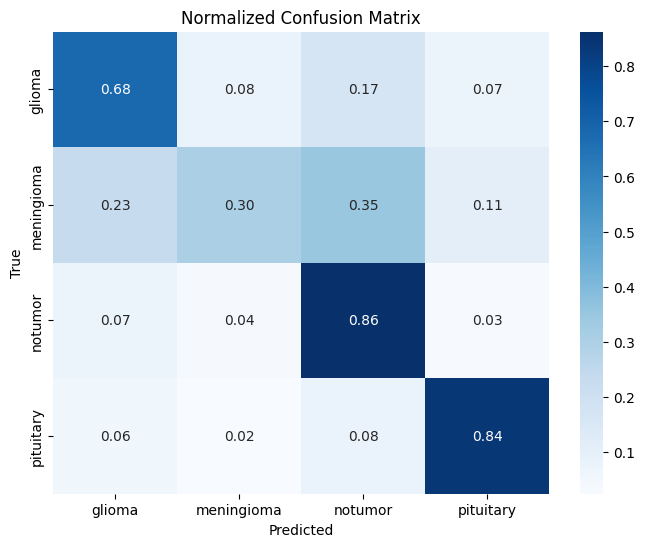

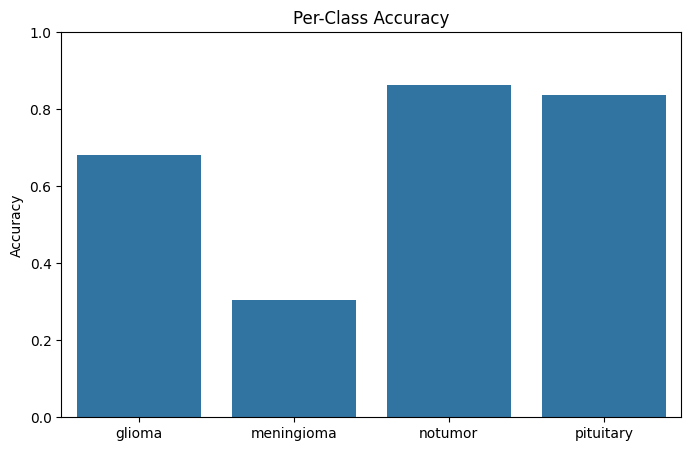

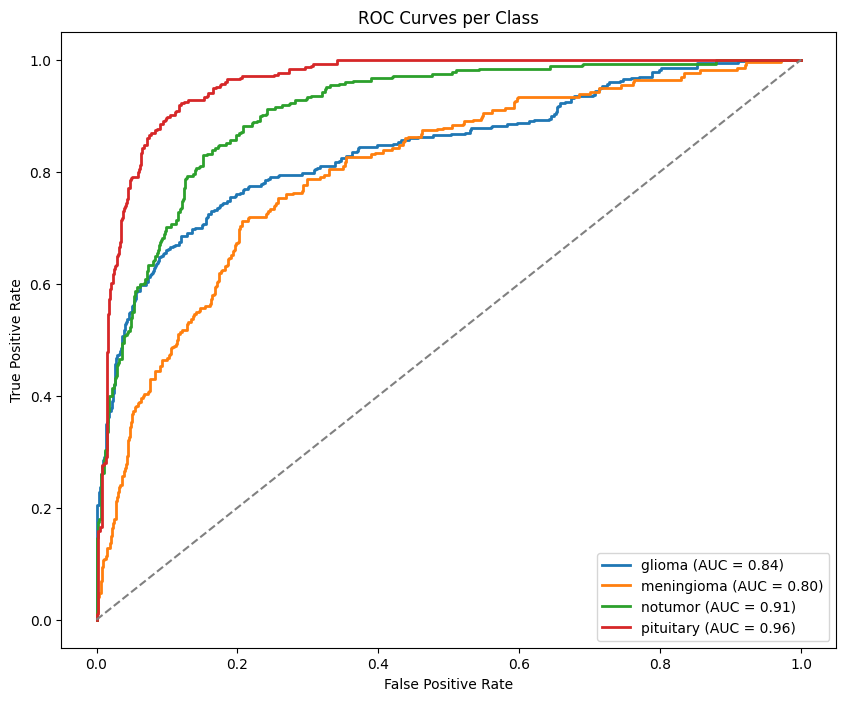

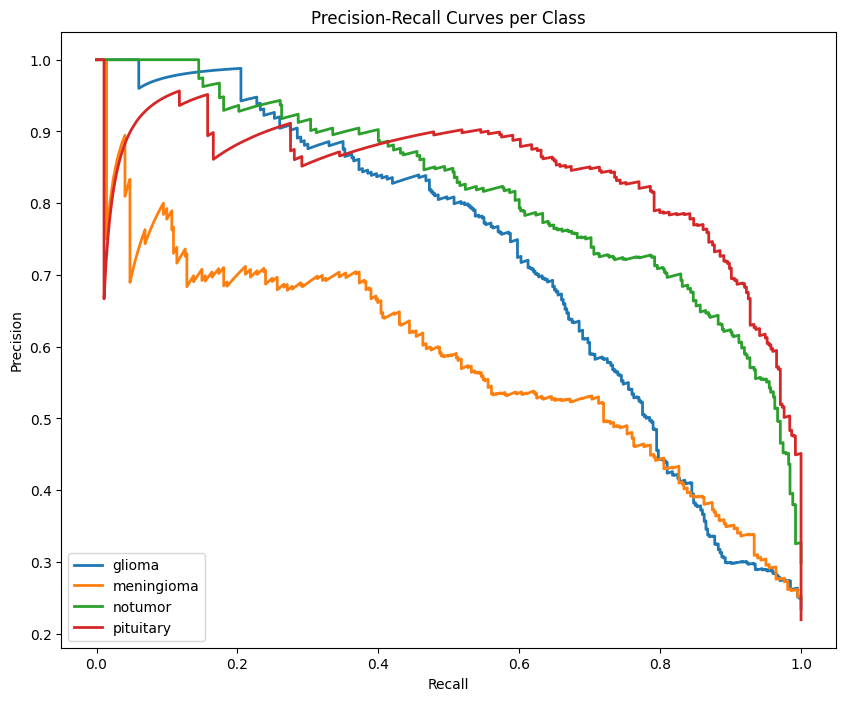

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    roc_curve, auc, precision_recall_curve
)
import tensorflow as tf

# -----------------------------
# 1. Load model
# -----------------------------
model = load_model("fine_tuned_radimagenet_model.h5")

# -----------------------------
# 2. Predictions on combined test set
# -----------------------------
test_generators = [test_gen1, test_gen2]
y_preds_prob = []
y_trues = []

for gen in test_generators:
    y_prob = model.predict(gen)
    y_true = gen.classes
    y_preds_prob.append(y_prob)
    y_trues.append(y_true)

y_true = np.concatenate(y_trues)
y_preds_prob = np.concatenate(y_preds_prob)
y_pred = np.argmax(y_preds_prob, axis=1)

class_labels = list(test_gen1.class_indices.keys())
n_classes = len(class_labels)

# -----------------------------
# 3. Basic Metrics
# -----------------------------
acc = accuracy_score(y_true, y_pred)
print(f"Overall Accuracy: {acc:.4f}\n")
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.show()

# Per-class Accuracy Bar Plot
per_class_acc = cm.diagonal() / cm.sum(axis=1)
plt.figure(figsize=(8, 5))
sns.barplot(x=class_labels, y=per_class_acc)
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Per-Class Accuracy')
plt.show()

# -----------------------------
# 4. ROC & AUC (One-vs-Rest)
# -----------------------------
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve((y_true == i).astype(int), y_preds_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{class_labels[i]} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves per Class")
plt.legend(loc="lower right")
plt.show()

# -----------------------------
# 5. Precision-Recall Curves
# -----------------------------
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve((y_true == i).astype(int), y_preds_prob[:, i])
    plt.plot(recall, precision, lw=2, label=f"{class_labels[i]}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves per Class")
plt.legend(loc="lower left")
plt.show()